# LUT Photo analysis

This notebook uses precomputed lookup tables to analyze the colors of photos

## Import dependencies and load data

In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import sys

sys.path.append("./src/")
import imageio
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import photo_analysis_functions as src
from sklearn.cluster import KMeans
from tmm.tmm_core import coh_tmm
from tqdm import tqdm

# ==== User selected parameters === #
CMFsfile = r"./Metadata/v5_CCD_CMFs_lu.npy"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/realG_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/cellB_LU_crop_1ms.tif"

# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/realE_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/S14_exp7_lu.tif"

# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/fakeG1_LU_crop.tif"

# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Green11_LU_straight.tif"

# photo_file = r"./photo_data/Green11_LU_inside.tif"
photo_file = r"./photo_data/Green11_LU_straight_darkBG.tif"

# photo_file = r"./photo_data/Green11_LU_inside_allgreen.tif"


# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Pink2_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Pink10_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Pink3_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Pink7_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/Pink10_LU_crop.tif"
# photo_file = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Real cells/crops/fake12_LU_crop.tif"


# Load vectors and lookup table
dvec = np.load("./Metadata/v4_LUT_dvec.npy")
nvec = np.load("./Metadata/v4_LUT_nvec.npy")
LU_LUT = np.load("./Metadata/v4_LU_LUT_ext.npy")

colors_to_analyze = 7  # Number of colors to reduce the image to for analysis

# === Readable font size in plots == #

# plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams.update({"font.size": 14})
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.fonttype"] = 42

## Define image analysis functions

In [168]:
def make_displayable(image, scaling=4):
    """Normalizes the 12 bit image to 0-1
    Inputs:
        Image - np array of 12 bit image
        scaling - Multiplier for all values in case the image is too dark
    Outputs:
        displayable_image - np array of 0-1 values image"""
    displayable_image = image / 2**14 * scaling
    displayable_image[displayable_image > 1] = 1

    return displayable_image


def reduce_colors(image, ncolors):
    """Reduces the image to its main n colors
    Inputs:
        Image - np array of 12 bit image
        ncolors - (int) number of colors to reduce the image to

    Outputs:
        main_colors - np array vector of the main RGB values of the image
        reduced_image - np array with the 12 bit reduced colors image"""

    # Flatten image to a vector of RGB triplets
    image_RGB_vector = image.reshape((-1, 3))
    # Allocate reduced image space
    reduced_image = image_RGB_vector.copy()
    # Find cluster centers
    clt = KMeans(n_clusters=ncolors, verbose=False).fit(image_RGB_vector)

    main_colors = clt.cluster_centers_

    # Make reduced colors image
    reduced_image = main_colors[clt.labels_].reshape(image.shape)

    return main_colors, reduced_image, clt.labels_

## Load image and reduce colors

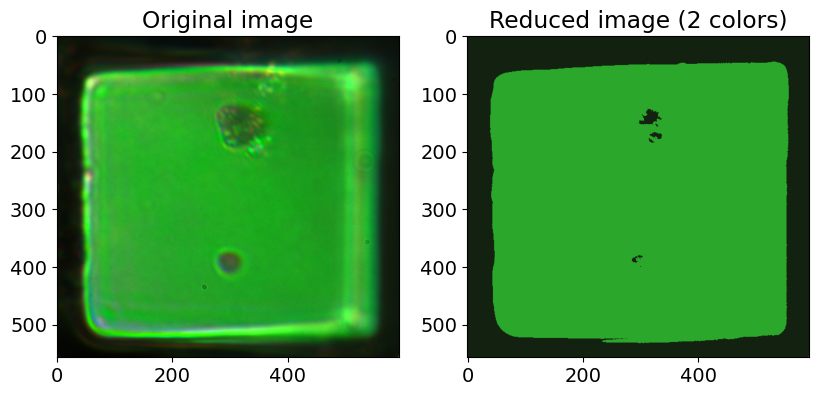


Global max percent error: 1.33


In [169]:
raw_photo = imageio.v2.imread(photo_file)  # Read the photo as 3D matrix of RGB values.
colors_to_analyze = 2

# 3 is pretty good
# 4 is pretty good too
# 6 gives best to sar, err = 1.97 in clusters

main_colors, reduced_photo, color_labels = reduce_colors(raw_photo, colors_to_analyze)

# Plot image and reduced image
fig, ax = plt.subplots(1, 2, figsize=(1.618 * 6, 6))

ax[0].imshow(make_displayable(raw_photo))
ax[0].set_title("Original image")
ax[1].imshow(make_displayable(reduced_photo))
ax[1].set_title("Reduced image ({} colors)".format(main_colors.shape[0]))

plt.show()

# Clustering error
src.cluster_variation(
    rawphoto=raw_photo, main_colors=main_colors, pixel_labels=color_labels
)

## Load color matching functions

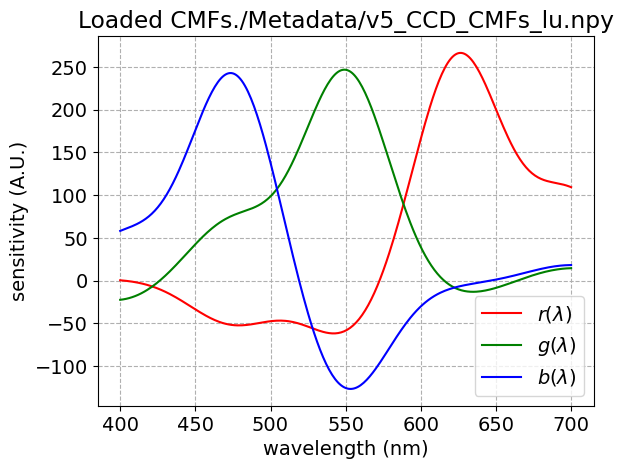

In [170]:
CMFS = np.load(CMFsfile)
lams = CMFS[:, 0]
RCMF = CMFS[:, 1]
GCMF = CMFS[:, 2]
BCMF = CMFS[:, 3]

plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
plt.xlabel("wavelength (nm)")
plt.ylabel("sensitivity (A.U.)")
plt.title("Loaded CMFs" + CMFsfile)
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

## Define spectra to RGB functions

In [171]:
from scipy.optimize import brute, minimize
from tmm.tmm_core import coh_tmm


def get_ref_spectra_dlst_nlst(wavs, dlst, nlst):
    """Compute the reflection spectra for series of thin films of constant refractive
    index and thickness. Upper layer first, substrate last.

    Inputs
        wavs [array] - Vector of wavelengths in nm
        dlst [array] - Vector of film thicknesses [nm]
        nlst [array] - Vector of film refractive indeces (avg over wavs)
    Output
        coh_tmm reflection [array] - Reflection spectra"""

    reflection = np.empty(wavs.shape)  # Allocate reflection vector
    dlst = [np.inf] + dlst + [np.inf]  # Add empty space before and after layers
    nlst = [1] + nlst + [1]  # Add refractive indeces of empty space

    for q, wav in enumerate(wavs):  # Compute reflection for every wavelength
        reflection[q] = coh_tmm("s", nlst, dlst, 0, wav)["R"]
    return reflection


def spec2rgb(spectra, CMFS):
    """Compute RGB values for a simulated thin film reflection spectra.
    Upper layer first, substrate last.

    Inputs
        spectra - Vector of reflection values for every wavelenght of the CMFs
        CMFs - Matrix containing color matching functions in each column
    Output
        coh_tmm reflection [array] - Reflection spectra"""

    RCMF = CMFS[:, 1]
    GCMF = CMFS[:, 2]
    BCMF = CMFS[:, 3]

    return np.array(
        [np.trapz(spectra * RCMF), np.trapz(spectra * GCMF), np.trapz(spectra * BCMF)]
    )


def film2rgb(d, n, CMFs):
    """Combines the two upper functions to compute the RGB triplet corresponding to
    a film of known thickness and refractive index"""
    spec = get_ref_spectra_dlst_nlst(lams, [d], [n])
    return spec2rgb(spec, CMFs)


def mse(vecA, vecB):
    """Computes the mean square error between two vectors
    Inputs:
        vecA - A numpy vector of any size
        vecB - A numpy vector of any size
    Outputs:
        mse - A number"""
    return 1 / vecA.size * np.sum((vecA - vecB) ** 2)

## LUT analysis of cluster pixels

Iterate over the pixels that fall into each cluster, find their cost function map, average them.

In [172]:
# --------- Parallel cluster processing -------- #
from joblib import Parallel, delayed

# Flatten image to a vector of RGB triplets
image_RGB_vector = raw_photo.reshape((-1, 3))

# Allocate recovered values vectors
nfound_vec = np.empty(colors_to_analyze)
dfound_vec = np.empty(colors_to_analyze)
found_RGB_vec = np.empty(main_colors.shape)

print(
    "Computing thickness and refractive index values for {} color clusters in parellel".format(
        colors_to_analyze
    )
)


# ====================== #
def parallel_clusters(cluster_idx, num_pixels, th=1):

    # Extract pixels belonging to cluster
    cluster_pixels = image_RGB_vector[color_labels == cluster_idx]

    # Allocate cost function map space
    cost_gray = np.empty((LU_LUT.shape[0], LU_LUT.shape[1]))

    # Choose a set of random pixels in the cluster
    # If cluster size is small, use all pixels in cluster

    if cluster_pixels.shape[0] < num_pixels:
        # print('Cluster {} is small, using all pixels'.format(cluster_idx))
        random_pixels_idxs = np.arange(cluster_pixels.shape[0])
    else:
        random_pixels_idxs = np.random.choice(
            cluster_pixels.shape[0], num_pixels, replace=False
        )
    # Compute cost function map for set of cluster pixels, add all of them up
    for pixel in tqdm(cluster_pixels[random_pixels_idxs]):
        cost = (LU_LUT - pixel) ** 2
        cost = cost.sum(axis=2)  # make grayscale
        cost_gray += cost  # Sum R+G+B to create 2D array, add previous

        cost /= cost.max()  # Normalize pixel cost
        cost[cost > th] = 1  # Threshold cutoff to display only lowest points

    # Locate best matching thickness and refractive index from LUT
    nfound = nvec[np.unravel_index(np.argmin(cost_gray), cost_gray.shape)[0]]
    dfound = dvec[np.unravel_index(np.argmin(cost_gray), cost_gray.shape)[1]]

    # Store found values
    return nfound, dfound, film2rgb(dfound, nfound, CMFS), cost_gray


# ---- Analyze the pixels of each cluster --- #
result = Parallel(n_jobs=-1)(
    delayed(parallel_clusters)(cluster_idx, 1000)
    for cluster_idx in range(colors_to_analyze)
)
cost_grayvec = []
# Extract results into final vectors
for q, value in enumerate(result):
    nfound_vec[q] = value[0]
    dfound_vec[q] = value[1]
    found_RGB_vec[q] = value[2]
    cost_grayvec.append(value[3])

Computing thickness and refractive index values for 2 color clusters in parellel


100%|██████████| 1000/1000 [29:36<00:00,  1.78s/it]


## Display final results

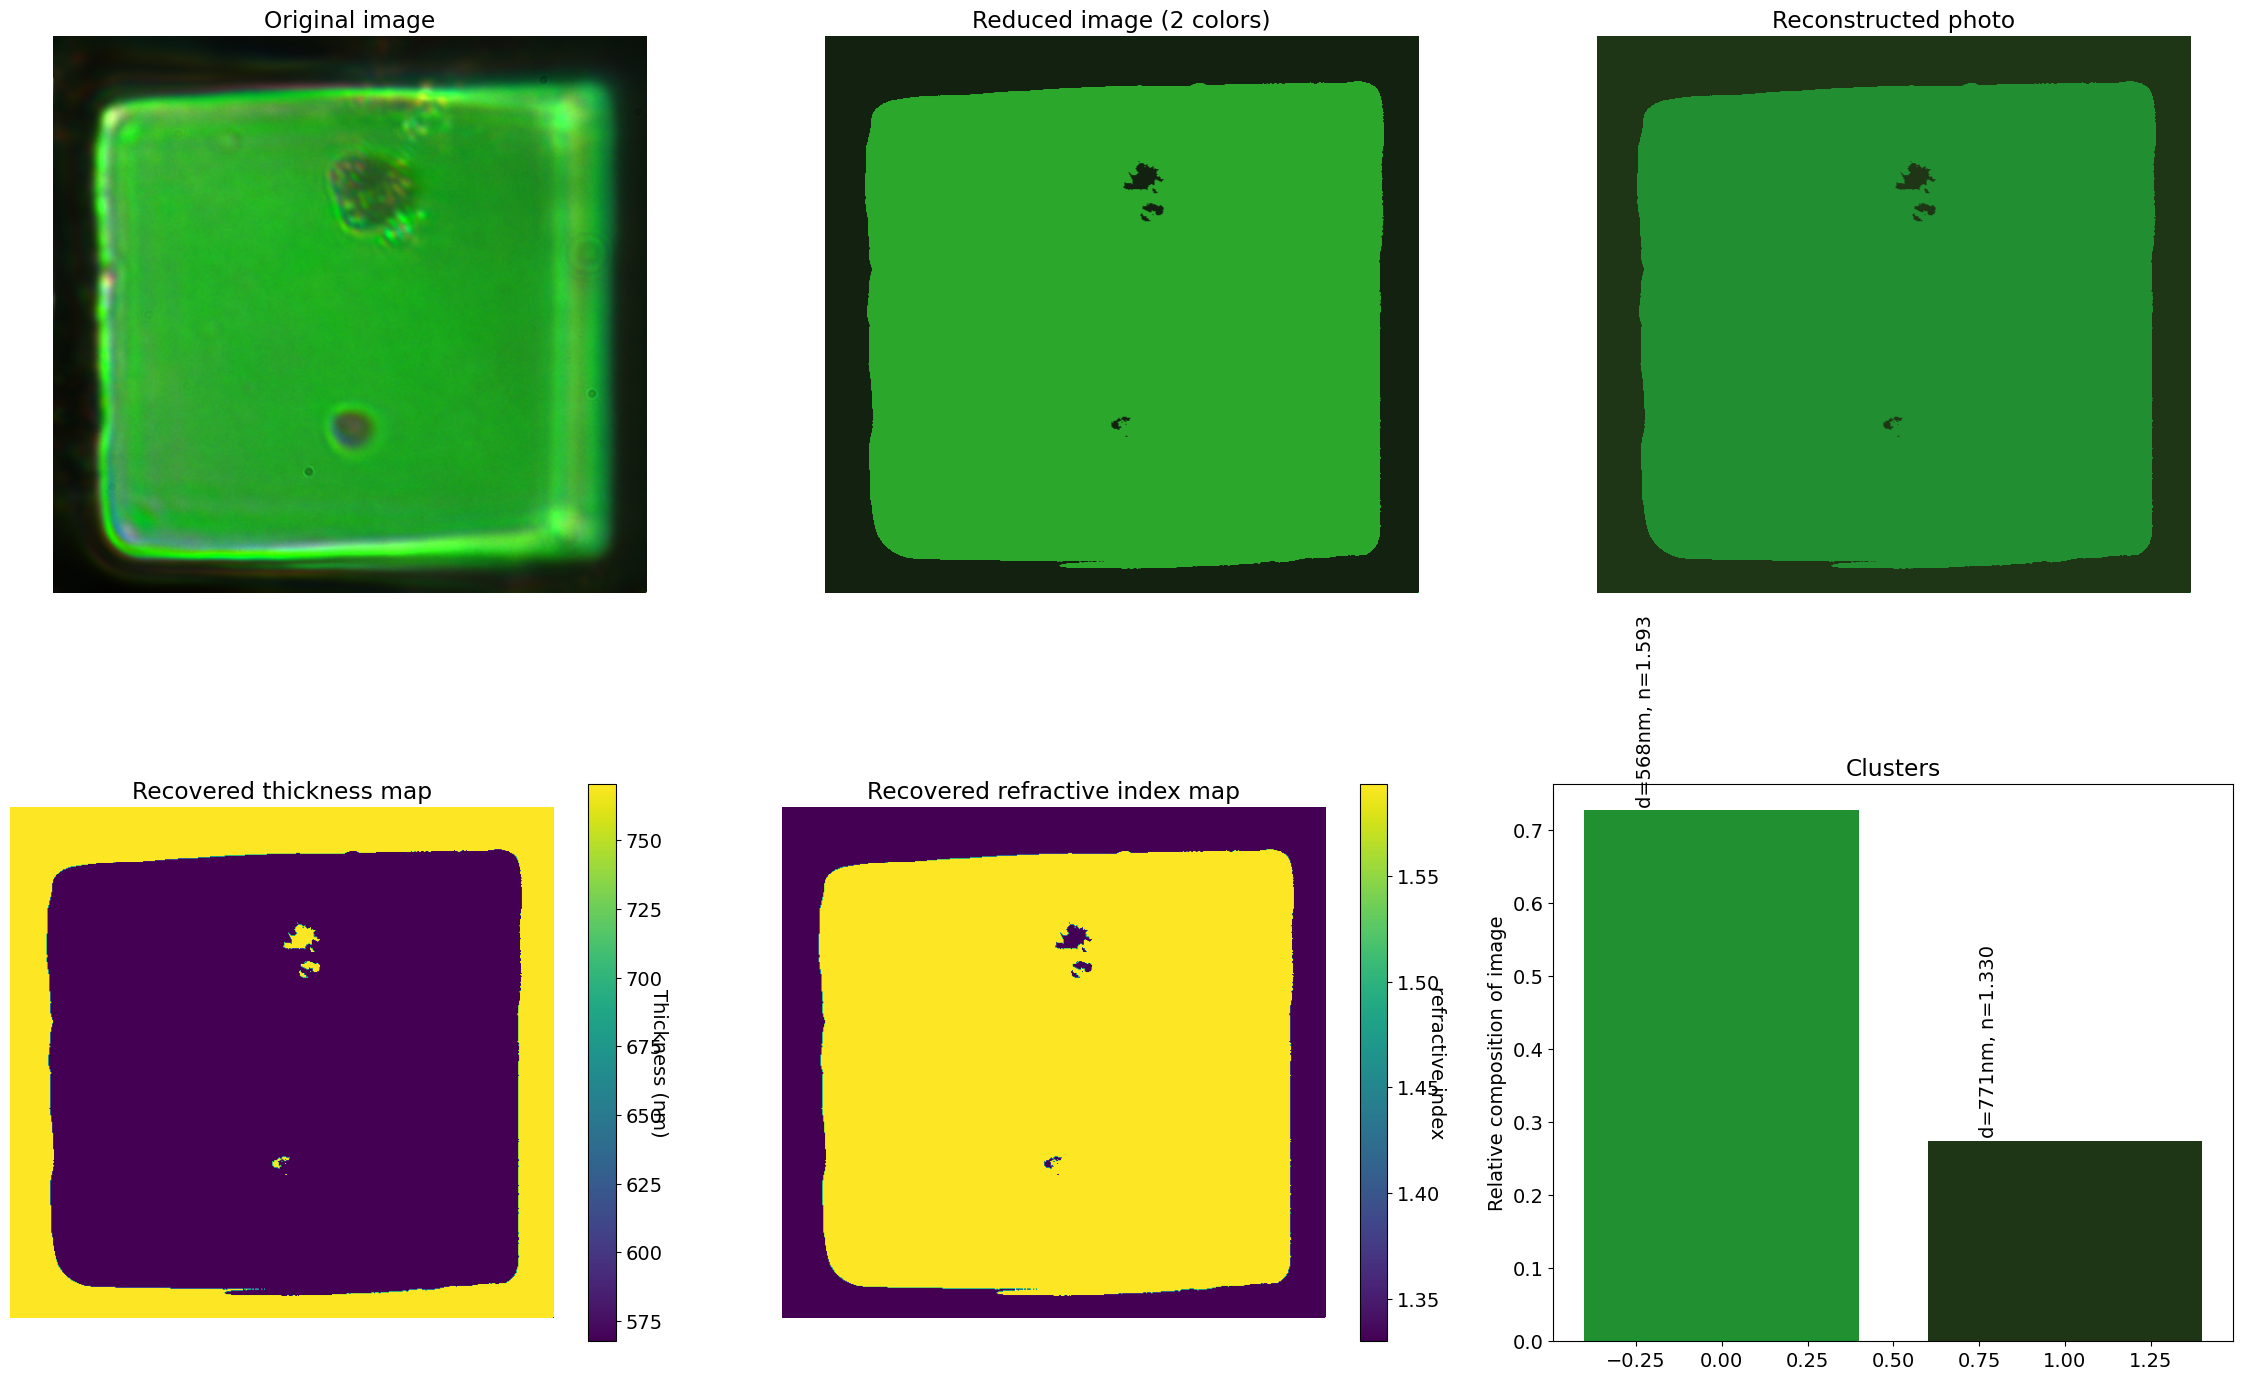

In [173]:
# Construct final results images
dimage = dfound_vec[color_labels].reshape(raw_photo.shape[0], raw_photo.shape[1])
nimage = nfound_vec[color_labels].reshape(raw_photo.shape[0], raw_photo.shape[1])
recon_image = found_RGB_vec[color_labels].reshape(raw_photo.shape)

# Save results
np.save("./lastrun/Fake_cell_nimage_{}_colors".format(colors_to_analyze), nimage)
np.save("./lastrun/Fake_cell_dimage_{}_colors".format(colors_to_analyze), dimage)
np.save(
    "./lastrun/Fake_cell_recon_image_{}_colors".format(colors_to_analyze), recon_image
)

# Plot all results
fig, ax = plt.subplots(2, 3, figsize=(1.618 * 14, 14))

ax[0, 0].imshow(make_displayable(raw_photo))
ax[0, 0].set_title("Original image")

ax[0, 1].imshow(make_displayable(reduced_photo))
ax[0, 1].set_title("Reduced image ({} colors)".format(main_colors.shape[0]))

ax[0, 2].imshow(make_displayable(recon_image))
ax[0, 2].set_title("Reconstructed photo")

im1 = ax[1, 0].imshow(dimage, origin="lower")
ax[1, 0].invert_yaxis()
ax[1, 0].set_title("Recovered thickness map")
bar1 = fig.colorbar(im1, ax=ax[1, 0])
bar1.set_label("Thickness (nm)", rotation=270)

im2 = ax[1, 1].imshow(nimage, origin="lower")
ax[1, 1].invert_yaxis()
ax[1, 1].set_title("Recovered refractive index map")
bar2 = fig.colorbar(im2, ax=ax[1, 1])
bar2.set_label("refractive index", rotation=270)

for a in ax.ravel():
    a.axis("off")

composition = np.empty(colors_to_analyze)
for idx in range(colors_to_analyze):
    composition[idx] = color_labels[color_labels == idx].size / color_labels.size


ax[1, 2].axis("on")
ax[1, 2].set_title("Clusters")
ax[1, 2].set_ylabel("Relative composition of image")

clusters_rgb = 4 * found_RGB_vec / 2**14
clusters_rgb[clusters_rgb > 1] = 1
clusters_rgb[clusters_rgb < 0] = 0

ax[1, 2].bar(range(colors_to_analyze), composition, color=clusters_rgb)
for x, y, d, n in zip(range(colors_to_analyze), composition, dfound_vec, nfound_vec):
    ax[1, 2].text(x - 0.25, y + 0.01, "d={:.0f}nm, n={:.3f}".format(d, n), rotation=90)
    # ax[1, 2].text(x - 0.5, y + 0.02, "n={:.3f}".format(n),rotation=90)


plt.tight_layout()
plt.savefig(
    "./results/{}_{}clusters.pdf".format(
        photo_file.split("/")[-1][:-4], colors_to_analyze
    ),
    dpi=300,
)
plt.show()
# print(dfound_vec, nfound_vec)

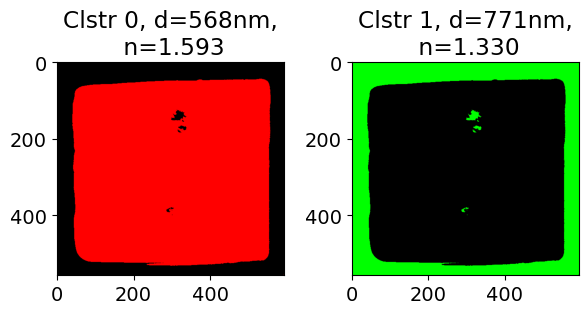

In [174]:
## Diplays clusters
import matplotlib.cm as cm

Cols = 4
Rows = colors_to_analyze // Cols
Rows += colors_to_analyze % Cols
Position = range(1, colors_to_analyze + 1)
fig = plt.figure(figsize=(12, 12 / 1.618))


def my_cycle(seq):
    while seq:
        for element in seq:
            yield element


# Custom colors in 14 bit format
colors_list = [
    [2**14, 0, 0],
    [0, 2**14, 0],
    [0, 0, 2**14],
    [2**14, 2**14, 0],
    [0, 2**14, 2**14],
    [2**14, 0, 2**14],
]
color_cycle = my_cycle(colors_list)
for k in range(colors_to_analyze):
    cluster_photo = reduced_photo.copy()
    # cluster_photo[:] = (0, 0, 255)
    # cluster_photo=np.empty(reduced_photo.shape)
    # cluster_photo[reduced_photo != main_colors[k]] = 1/4*2**14 # Make non-cluster pixels white
    cluster_photo[reduced_photo != main_colors[k]] = 0  # Make non-cluster pixels black
    cluster_photo[(cluster_photo != 0).all(-1)] = next(color_cycle)  # Color of cluster

    # cluster_photo=np.ma.masked_where(reduced_photo != main_colors[k],reduced_photo) # Make clusters transparent

    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows, Cols, Position[k])
    # ax.imshow(make_displayable(raw_photo))

    ax.imshow(make_displayable(cluster_photo))
    # ax.imshow(make_displayable(cluster_photo),cmap=cm.tab10,interpolation='none') # Or whatever you want in the subplot

    ax.set_title(
        "Clstr {}, d={:.0f}nm,\n n={:.3f}".format(k, dfound_vec[k], nfound_vec[k])
    )

plt.tight_layout()
plt.savefig(
    "./results/{}_{}clusters_clusters.pdf".format(
        photo_file.split("/")[-1][:-4], colors_to_analyze
    ),
    dpi=300,
)
plt.show()

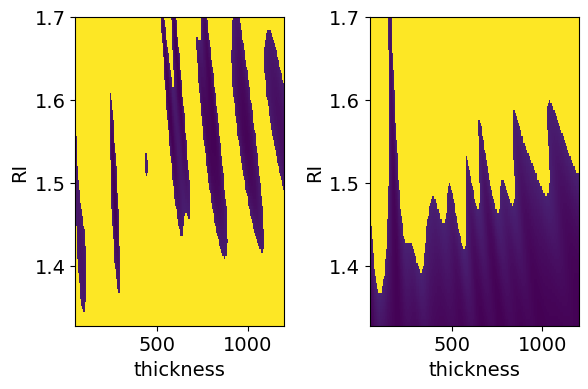

In [175]:
Cols = 4
Rows = colors_to_analyze // Cols
Rows += colors_to_analyze % Cols
Position = range(1, colors_to_analyze + 1)
fig = plt.figure(figsize=(12, 12 / 1.618))

for k in range(colors_to_analyze):

    # cluster_photo=np.ma.masked_where(reduced_photo != main_colors[k],reduced_photo) # Make clusters transparent

    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows, Cols, Position[k])
    costmap = cost_grayvec[k]
    costmap /= costmap.max()
    costmap[costmap > 0.1] = 1

    ax.pcolormesh(dvec[::40], nvec[::40], costmap[::40, ::40])
    ax.set_xlabel("thickness")
    ax.set_ylabel("RI")

plt.tight_layout()
plt.savefig(
    "./results/{}_{}clusters_cost_maps.pdf".format(
        photo_file.split("/")[-1][:-4], colors_to_analyze
    ),
    dpi=300,
)
plt.show()

## Error map for calibration cell in RI

In [70]:
error.shape

(557, 593)

1.593399999999971


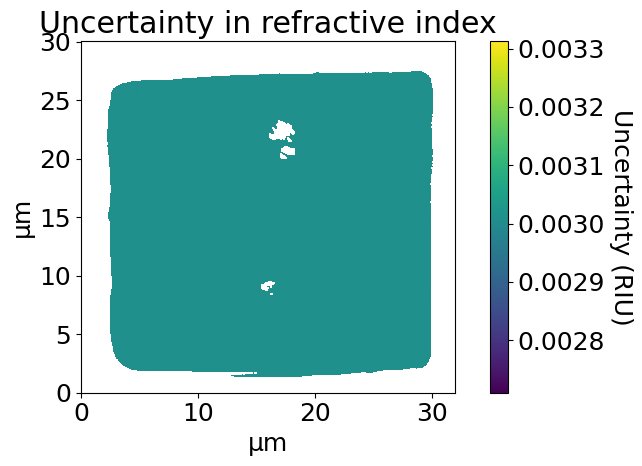

Mean error in RI 0.0030112363504879447


In [216]:
import matplotlib

x, y = np.meshgrid(np.arange(0, nimage.shape[1]), np.arange(0, nimage.shape[0]))
nimage = np.load("lastrun/Fake_cell_nimage_2_colors.npy")

nimage[nimage <= 1.33] = np.NaN
# nimage[nimage!=1.4838999999999831]=np.NaN
print(nimage[170,250])
plt.rcParams.update({"font.size": 18})
# nimageb = nimage.copy()

error = np.abs(nimage - 1.596411236350459)

plt.figure(figsize=(5 * 1.618, 5))
# Extent configured to scale image to µm
# plt.imshow(error,extent=[0,np.max(x / 18.5182),0,np.max(y / 18.5182)],norm=matplotlib.colors.LogNorm(vmin=1e-2))
plt.imshow(error, extent=[0, np.max(x / 18.5182), 0, np.max(y / 18.5182)])
plt.xlabel("µm")
plt.ylabel("µm")
bar1 = plt.colorbar()
bar1.set_label("Uncertainty (RIU)", rotation=270, labelpad=20)

plt.title("Uncertainty in refractive index")

plt.tight_layout()
plt.savefig(
    "./Fake_cell_results_3/RI_erorr_{}_colors.pdf".format(colors_to_analyze),
    bbox_inches="tight",
    transparent=True,
)
plt.show()

print("Mean error in RI", error[~np.isnan(error)].mean())

## Error map for calibration cell in thickness

[567.6 770.5]


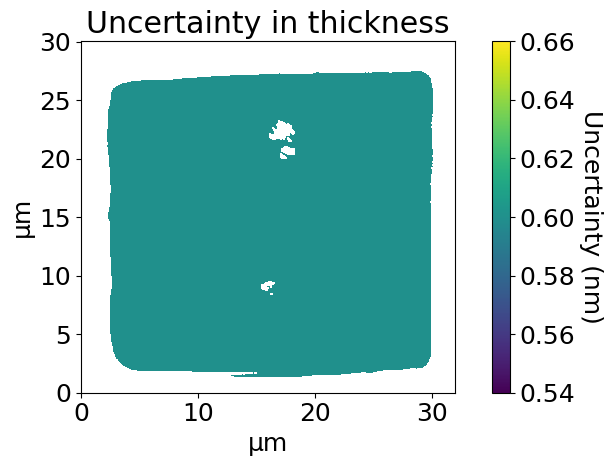

Mean error in thickness 0.6000000000074124


In [203]:
import matplotlib

dimage = np.load("lastrun/Fake_cell_dimage_2_colors.npy")
x, y = np.meshgrid(np.arange(0, dimage.shape[1]), np.arange(0, dimage.shape[0]))

plt.rcParams.update({"font.size": 18})
# nimageb = nimage
# nimageb[nimageb < 1.35] = 1.566

dimage[dimage>700]=np.NaN
# dimage[dimage==dfound_vec[0]]=np.NaN
# dimage[dimage == dfound_vec[1]] = np.NaN
# dimage[dimage==dfound_vec[2]]=np.NaN

error = np.abs(dimage - 567)
print(dfound_vec)

plt.figure(figsize=(5 * 1.618, 5))
# Extent configured to scale image to µm
# plt.imshow(error,extent=[0,np.max(x / 18.5182),0,np.max(y / 18.5182)],norm=matplotlib.colors.LogNorm(vmin=1e-2))
plt.imshow(error, extent=[0, np.max(x / 18.5182), 0, np.max(y / 18.5182)])
plt.xlabel("µm")
plt.ylabel("µm")
bar1 = plt.colorbar()
bar1.set_label("Uncertainty (nm)", rotation=270, labelpad=20)
plt.title("Uncertainty in thickness")
plt.tight_layout()
plt.savefig(
    "./Fake_cell_results_3/Thick_error_{}_colors.pdf".format(colors_to_analyze),
    bbox_inches="tight",
    transparent=True,
)
plt.show()

print("Mean error in thickness", error[~np.isnan(error)].mean())

30.078517350498426 32.02255078787355


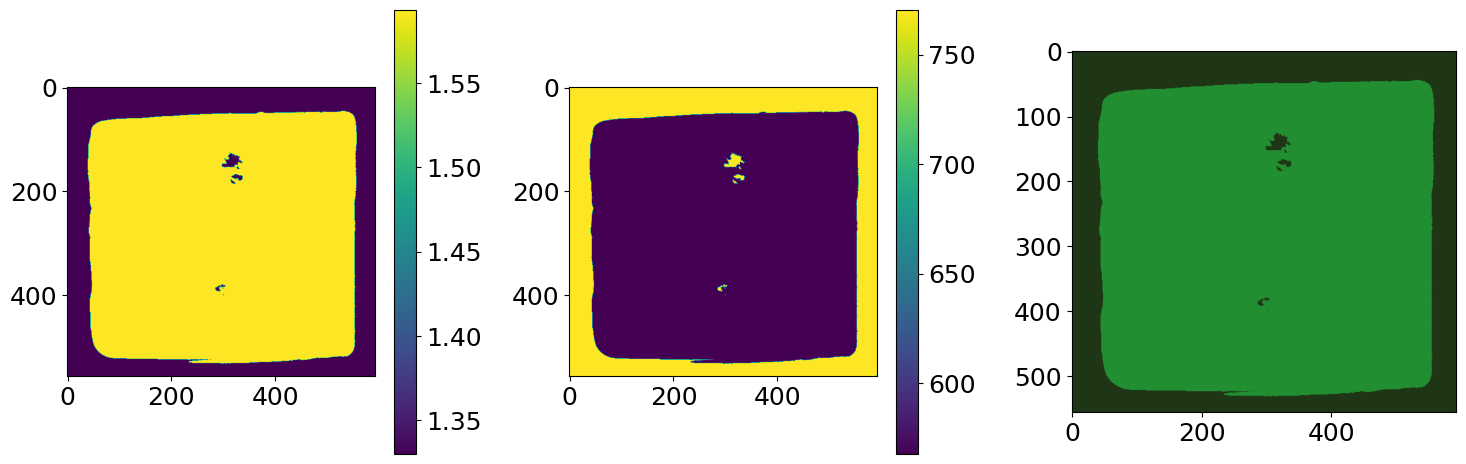

In [198]:
# Load data

nimage = np.load("lastrun//Fake_cell_nimage_2_colors.npy")
dimage = np.load("lastrun//Fake_cell_dimage_2_colors.npy")
recon_image = np.load("lastrun//Fake_cell_recon_image_2_colors.npy")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# nimage[nimage<=1.33]=1.45 # Optimize colorbars range
# dimage[dimage<300]=570

im1 = ax[0].imshow(nimage)
im2 = ax[1].imshow(dimage)
ax[2].imshow(src.make_displayable(recon_image))
bar1 = fig.colorbar(im1, ax=ax[0])
bar2 = fig.colorbar(im2, ax=ax[1])
plt.tight_layout()
plt.savefig(
    "./Render_assets/forcolorbars_{}_colors.pdf".format(colors_to_analyze),
    bbox_inches="tight",
)

plt.imsave(
    "./Render_assets/fake_cell_RI_{}_colors.png".format(colors_to_analyze), nimage
)
plt.imsave(
    "./Render_assets/fake_cell_thick_{}_colors.png".format(colors_to_analyze), dimage
)
plt.imsave(
    "./Render_assets/fake_cell_RI_disp_{}_colors.png".format(colors_to_analyze),
    nimage,
    cmap="gray",
)
plt.imsave(
    "./Render_assets/fake_cell_thick_disp_{}_colors.png".format(colors_to_analyze),
    dimage,
    cmap="gray",
)
plt.imsave(
    "./Render_assets/fake_cell_recon_{}_colors.png".format(colors_to_analyze),
    src.make_displayable(recon_image),
)

print(nimage.shape[0] / 18.5182, nimage.shape[1] / 18.5182)

## 3D thickness map

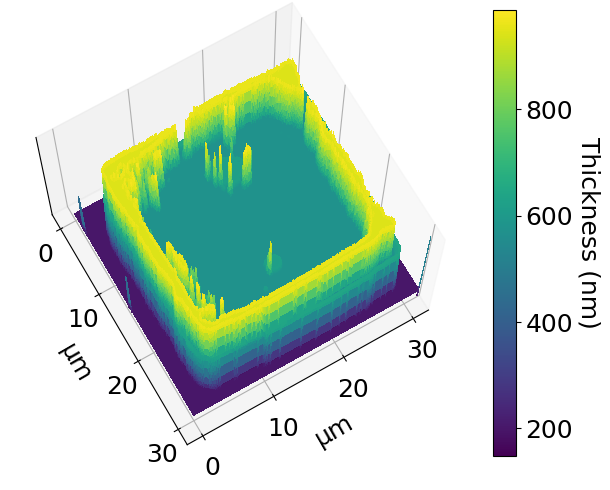

In [69]:
# dimage_smooth = gaussian_filter(dimage,5)
# plt.figure()
# plt.imshow(dimage_smooth)
plt.rcParams.update({"font.size": 18})


from scipy.signal import savgol_filter

# dimage[dimage > 750] = 0  # Correct background for fake cell

dimage_smooth = savgol_filter(dimage, 7, 3, axis=0)
dimage_smooth = savgol_filter(dimage_smooth, 7, 3, axis=1)
# dimage_smooth = gaussian_filter(dimage_smooth,5)

# plt.figure()
# plt.imshow(dimage_smooth)

fig = plt.figure(figsize=(5 * 1.618, 5))
ax = fig.add_subplot(projection="3d")
from matplotlib.colors import LightSource

ls = LightSource(azdeg=315, altdeg=45)
from matplotlib import cm
from scipy.ndimage import gaussian_filter

# rgb = ls.shade(dimage, cmap=cm.viridis, vert_exag=0.1, blend_mode='hsv')


x, y = np.meshgrid(np.arange(0, dimage.shape[1]), np.arange(0, dimage.shape[0]))

im1 = ax.plot_surface(
    x / 18.5182,
    y / 18.5182,
    dimage_smooth,
    rcount=600,
    ccount=600,
    cmap="viridis",
    aa=False,
    linewidth=0,
    rasterized=True,
)
# im1 = ax.plot_surface(x,y,dimage_smooth,rcount=100,ccount=100,facecolors=rgb)

ax.view_init(70, 90 - 30)
ax.invert_yaxis()
# ax.invert_xaxis()

ax.set_xlabel("µm", rotation=30, labelpad=10)
ax.set_ylabel("µm", rotation=270 + 30, labelpad=10)
# ax.set_title("Cellular thickness map")
bar1 = fig.colorbar(im1, ax=ax)
bar1.set_label("Thickness (nm)", rotation=270, labelpad=20)
ax.set_zticks([])
plt.tight_layout()
plt.savefig("calib inside 3D thickness 3.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 3D refractive index map

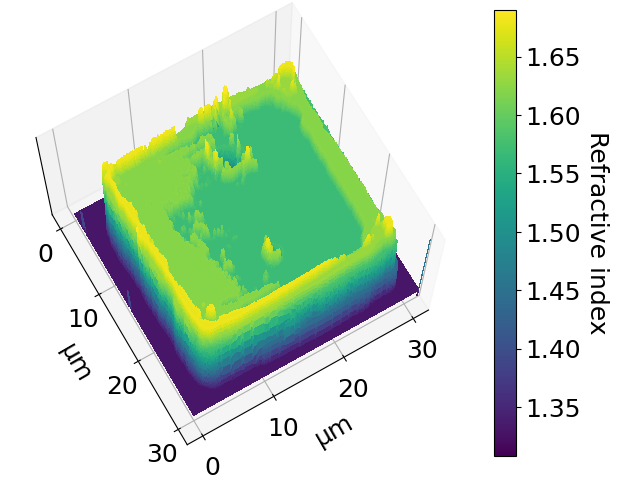

In [69]:
# nimage_smooth = gaussian_filter(nimage,5)
# plt.figure()
# plt.imshow(nimage_smooth)
plt.rcParams.update({"font.size": 18})


from scipy.signal import savgol_filter

# nimage[nimage>750]=0 # Correct background for fake cell

nimage_smooth = savgol_filter(nimage, 7, 3, axis=0)
nimage_smooth = savgol_filter(nimage_smooth, 7, 3, axis=1)
# nimage_smooth = gaussian_filter(nimage_smooth,5)

# plt.figure()
# plt.imshow(nimage_smooth)

fig = plt.figure(figsize=(5 * 1.618, 5))
ax = fig.add_subplot(projection="3d")
from matplotlib.colors import LightSource

ls = LightSource(azdeg=315, altdeg=45)
from matplotlib import cm
from scipy.ndimage import gaussian_filter

# rgb = ls.shade(nimage, cmap=cm.viridis, vert_exag=0.1, blend_mode='hsv')


x, y = np.meshgrid(np.arange(0, nimage.shape[1]), np.arange(0, nimage.shape[0]))

im1 = ax.plot_surface(
    x / 18.5182,
    y / 18.5182,
    nimage_smooth,
    rcount=600,
    ccount=600,
    cmap="viridis",
    aa=False,
    linewidth=0,
    rasterized=True,
)
# im1 = ax.plot_surface(x,y,nimage_smooth,rcount=100,ccount=100,facecolors=rgb)

ax.view_init(70, 90 - 30)
ax.invert_yaxis()
# ax.invert_xaxis()

ax.set_xlabel("µm", rotation=30, labelpad=10)
ax.set_ylabel("µm", rotation=270 + 30, labelpad=10)
# ax.set_title("Cellular thickness map")
bar1 = fig.colorbar(im1, ax=ax)
bar1.set_label("Refractive index", rotation=270, labelpad=20)
ax.set_zticks([])
plt.tight_layout()
plt.savefig("calib inside 3D refractive 3.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [15]:
# np.save('Fake_cell_v4LUT_nimage',nimage)
# np.save('Fake_cell_v4_LUT_dimage',dimage)